<a href="https://colab.research.google.com/github/Wook43/Baekjoon-Study/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기본 세팅

In [1]:
# 라이브러리 설치
!pip install -q transformers accelerate sentencepiece

In [2]:
# 라이브러리 import
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import torch.nn.functional as F
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [8]:
# Google Drive 마운트
drive.mount('/content/drive')

# 파일 경로 설정
path = "/content/drive/MyDrive/인공지능2/project/같은 단어, 다른 마음:'행복'을 이해하는 시선_(응답).xlsx"

# cpu/gpu 설정
device = 0 if torch.cuda.is_available() else -1

# 다국어 Zero-shot 모델
zs_global = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=device)

'''AI tool 사용'''
# 한국어 NLI 모델
kor_model_name = "ehdwns1516/klue-roberta-base-kornli"
tok_ko = AutoTokenizer.from_pretrained(kor_model_name)
kor_model = AutoModelForSequenceClassification.from_pretrained(kor_model_name)

if device >= 0:
  kor_model.to(device)

id2label = kor_model.config.id2label
entail_idx = [i for i, lab in id2label.items() if "entail" in lab.lower()][0]

'''AI tool 사용'''
# 그래프 한글 패치
# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# NanumGothic 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name)

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Device set to use cuda:0


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## 데이터 불러오기 및 전처리

In [177]:
# 데이터 불러오기
df_raw = pd.read_excel(path)

display(df_raw.head())

,타임스탬프,단어 - 1줄 설명 (1/10),단어 - 1줄 설명 (2/10),단어 - 1줄 설명 (3/10),단어 - 1줄 설명 (4/10),단어 - 1줄 설명 (5/10),단어 - 1줄 설명 (6/10),단어 - 1줄 설명 (7/10),단어 - 1줄 설명 (8/10),단어 - 1줄 설명 (9/10),단어 - 1줄 설명 (10/10)
0,2025-11-20 11:59:07.546,자유 - 모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다,만족 - 행복은 더이상 무언가 바랄 것이 없는 상태일 것이다,완전 - 행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함,무욕 - 행복한 상태는 이미 충분하기에 더한 욕심도 없을 것,충분 - 행복하다면 이미 채워져있어 부족함이 없을 것,걱정 - 아무런 고민이나 우려가 없으면 행복할 것 같다.,"평안 - 걱정도 없고, 만족하기에 늘 잔잔하고 안정적임",안정 - 삶의 큰 요동이 없는 것이 행복이지 않을까,스트레스 - 어떤 스트레스도 없으면 행복할 것 같아서,의무 - 나를 옭아매는 책임과 의무들로부터 벗어났을 때 행복하지 않을까 싶다
1,2025-11-22 18:41:14.463,사랑 - 사랑을 나눌 때 행복하다,기쁨 - 행복한 생활에는 기쁨이 가득,감사 - 행복에는 감사가 넘친다,섬김 - 행복한 삶은 서로 섬김에서 이루어진다,교제 - 함께 할 때 행복이 이루어진다,웃음 - 행복할 때 웃음이 나온다,나눔 - 서로 나누는 삶을 통해 행복을 이룬다,이해 - 서로 이해하며 살아갈 때 행복의 열매를 맺는다,용서 - 미움은 나를 힘들게한다.,평안 - 평안한 생활은 행복한 삶을 이룬다
2,2025-11-22 19:33:58.579,안정 - 안정되어야 행복이 찾아온다,풍족 - 풍족하면 행동이 더 찾아온다,"사랑 - 사랑은 행복을 주기도, 행복해야 할 수 있기도 함",타인 - 행복은 타인과 나와의 관계에서 찾을 수 있기도 하다,불행 - 행복의 반대는 불행,삶 - 삶은 행복도 불행도 가져온다,노래 - 노래의 주 단어나 주제로 행복을 사용하기도,포괄 - 행복은 긍정적 상태를 포괄하는 단어이기도,눈 - 누군가의 눈을 보면 행복해지는 때가 있다,완전 - 행복하다는 것은 곧 완전하다는 상태
3,2025-11-23 16:49:10.177,의식주 - 일상생활에 밀접하므로 의식주에 만족감이 높으면 행복할 수 밖에 없다.,돈 - 원하는 것들을 대부분 부담 없이 할 수 있다.,인간관계 - 사람의 걱정거리는 대부분 인간관계에서 비롯된다.,행운 - 뜻밖에 행운은 행복감을 준다.,여행 - 무료한 일상을 벗어나 새로운 경험과 자유를 느끼게 해준다.,성취감 - 계획을 세우고 목표를 향해 나아가는 과정과 달성하는 순간은 사람에게 행복...,침대 - 뒹굴거리는 순간이 행복하다.,동물영상 - 귀여운 동물들을 보는 것만으로도 행복함을 느낀다.,디저트 - 진짜 맛있는 디저트는 기분을 좋게 만들어 준다.,잠 - 충분한 잠을 잔 하루는 일어날 때부터 행복하다.
4,2025-11-23 16:52:13.410,가족-함께 있으면 행복한 사람,사랑-사랑할 때는 행복하죠,배우자-사랑하는 사람,자녀-보고만 있어도 행복함,성공-성공하면 기쁘니까,만족-만족함인 상태일 때 행복감을 느낌,취미-좋아하는 일을 할 때는 행복함,음식-맛있는 음식은 최고의 가성비로 행복감을 주는듯함,잠-편안한 잠은 최고의 행복,기쁨-기쁠때 행복함을 느낌


In [178]:
# 단어 / 설명을 각 행으로 구분

# "단어 - 1줄 설명 (1/10)" 형식의 컬럼 추출
word_cols = [c for c in df_raw.columns if '단어 - 1줄 설명' in c]

# 응답자를 구분할 ID 컬럼 설정 = 행 번호
df_raw['respondent_id'] = df_raw.index.astype(str)

rows = []
for _, row in df_raw.iterrows():
    respondent_id = row['respondent_id']

    for i, col in enumerate(word_cols, start=1):
        value = row[col]

        if pd.isna(value):
            continue

        word, explanation = str(value).split('-', 1)

        word = word.strip()
        explanation = explanation.strip()

        rows.append({
            'respondent_id': respondent_id,
            'pair_index': i,
            'word': word,
            'explanation': explanation,
            'combined': word+" / "+explanation
        })

df = pd.DataFrame(rows)
display(df.head(5))

,respondent_id,pair_index,word,explanation,combined
0,0,1,자유,모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다,자유 / 모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다
1,0,2,만족,행복은 더이상 무언가 바랄 것이 없는 상태일 것이다,만족 / 행복은 더이상 무언가 바랄 것이 없는 상태일 것이다
2,0,3,완전,행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함,완전 / 행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함
3,0,4,무욕,행복한 상태는 이미 충분하기에 더한 욕심도 없을 것,무욕 / 행복한 상태는 이미 충분하기에 더한 욕심도 없을 것
4,0,5,충분,행복하다면 이미 채워져있어 부족함이 없을 것,충분 / 행복하다면 이미 채워져있어 부족함이 없을 것


## Label 설정


In [11]:
label2name = {
    "평온과 안락" : "S", # Serenity
    "즐거움과 기쁨" : "P", # Pleasure
    "성취와 의미" : "A", # Achievement
    "관계와 유대" : "C", # Connection
}
names = list(label2name.values())
labels = list(label2name.keys())

## Zero-shot classification

In [179]:
# 다국어 Zero-Shot Score 함수
def global_zs_scores(text: str, labels, label2name, zs_pipeline, template: str = "{}"):
    res = zs_pipeline(
        text,
        candidate_labels=labels,
        multi_label=True,
        hypothesis_template=template
    )
    label2score_long = {lab: sc for lab, sc in zip(res["labels"], res["scores"])}

    scores_by_name = {}
    for long_text, name in label2name.items():
        scores_by_name[name] = float(label2score_long[long_text])

    return scores_by_name

In [180]:
'''AI tool 활용'''
# 한국어 NLI Score 함수
def kor_nli_scores(text:str, labels, label2name, tokenizer, model, entail_idx:int, max_length:int=256):
  scores = []

  for long_label in labels:
    hypo = long_label
    combined = text + tokenizer.sep_token+hypo

    encoded = tokenizer(combined, return_tensors="pt", truncation=True, max_length=max_length)
    if device >= 0:
      encoded = {k:v.to(device) for k, v in encoded.items()}

    with torch.no_grad():
      out=model(**encoded)
      probs = F.softmax(out.logits, dim=-1)[0].cpu().numpy()

    entail_score = probs[entail_idx]
    scores.append(entail_score)

  scores_by_name = {}
  for long_label, s in zip(labels, scores):
    name = label2name[long_label]
    scores_by_name[name] = float(s)

  return scores_by_name

In [181]:
# 모델 앙상블
def ensemble_axis_scores(text: str, axis_names, labels, label2name, zs_pipeline, tokenizer, nli_model, entail_idx: int, template, alpha: float = 0.7):
    # 글로벌 zero-shot 점수
    global_scores = global_zs_scores(
        text=text,
        labels=labels,
        label2name=label2name,
        zs_pipeline=zs_pipeline,
        template=template,
    )

    # 한국어 NLI 점수
    ko_scores = kor_nli_scores(
        text=text,
        labels=labels,
        label2name=label2name,
        tokenizer=tokenizer,
        model=nli_model,
        entail_idx=entail_idx,
    )

    # 가중 평균 앙상블
    final_raw = {}
    for name in axis_names:
        g = global_scores[name]
        k = ko_scores[name]
        final_raw[name] = alpha * g + (1 - alpha) * k

    return {
        "raw": final_raw,
        "global_only": global_scores,
        "korean_only": ko_scores,
    }

In [182]:
# 메소드 wrapper
def new_scores(text: str, template, alpha: float = 0.7):
    return ensemble_axis_scores(
        text=text,
        axis_names=names,
        labels=labels,
        label2name=label2name,
        zs_pipeline=zs_global,
        tokenizer=tok_ko,
        nli_model=kor_model,
        entail_idx=entail_idx,
        alpha=alpha,
        template=template,
    )

In [183]:
# 전체 SPAC score 계산
alpha = 0.3 # 단어 비중
beta = 0.7 # 설명 비중

for name in names:
  df[f"{name}_score_word"] = 0.0
  df[f"{name}_score_expl"] = 0.0
  df[f"{name}"] = 0.0

for idx, row in df.iterrows():
  word = row['word']
  expl = row['explanation']

  scores_word = new_scores(word, "이 단어는 {}과 관련된 행복을 나타낸다.", 0.7)
  scores_expl = new_scores(expl, "이 설명은 {}과 관련된 행복을 말한다.", 0.3)

  current_row_combined_scores = {}

  for name in names:
    sw = scores_word['raw'][name]
    se = scores_expl['raw'][name]
    # 단어/설명 앙상블
    sc = (alpha * sw + beta * se)

    df.loc[idx, f"{name}_score_word"] = sw
    df.loc[idx, f"{name}_score_expl"] = se
    current_row_combined_scores[name] = sc

  # 순위에 따라 점수 부여
  rank_values = [10.0, 7.5, 5.0, 2.5]

  sorted_names_by_score = sorted(current_row_combined_scores.items(), key=lambda item: item[1], reverse=True)

  for i, (name, _) in enumerate(sorted_names_by_score):
    if i < len(rank_values):
      df.loc[idx, f"{name}"] = rank_values[i]

In [184]:
'''AI Tool 활용'''
# 결과 저장
df.to_feather('/content/drive/MyDrive/인공지능2/project/SPAC.feather')

## 응답자별 점수 집계 및 시각화

In [174]:
df = pd.read_feather("/content/drive/MyDrive/인공지능2/project/SPAC.feather")

In [176]:
df

,respondent_id,age,gender,emotion_level,pair_index,word,explanation,combined,P_score_word,P_score_expl,...,S_score,S,A_score_word,A_score_expl,A_score,A,C_score_word,C_score_expl,C_score,C
0,0,20대,남,2,1,자유,모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다,자유 / 모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다,0.927908,0.117962,...,0.917804,10.0,0.927007,0.385465,0.484695,5.0,0.896821,0.588507,0.835584,7.5
1,0,20대,남,2,2,만족,행복은 더이상 무언가 바랄 것이 없는 상태일 것이다,만족 / 행복은 더이상 무언가 바랄 것이 없는 상태일 것이다,0.946885,0.390512,...,0.450994,10.0,0.935575,0.328812,0.384236,5.0,0.910554,0.301950,0.449037,2.5
2,0,20대,남,2,3,완전,행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함,완전 / 행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함,0.887642,0.744871,...,0.739942,7.5,0.871726,0.424381,0.399561,2.5,0.836830,0.508991,0.659461,5.0
3,0,20대,남,2,4,무욕,행복한 상태는 이미 충분하기에 더한 욕심도 없을 것,무욕 / 행복한 상태는 이미 충분하기에 더한 욕심도 없을 것,0.731144,0.811374,...,0.882874,10.0,0.727976,0.787207,0.854371,5.0,0.692604,0.503704,0.723238,2.5
4,0,20대,남,2,5,충분,행복하다면 이미 채워져있어 부족함이 없을 것,충분 / 행복하다면 이미 채워져있어 부족함이 없을 것,0.928624,0.843399,...,0.850098,5.0,0.901846,0.857196,0.927580,10.0,0.873279,0.648615,0.838503,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,22,20대,남,1,6,건강,행복의 필요조건,건강 / 행복의 필요조건,0.926400,0.741518,...,0.808916,5.0,0.903955,0.735182,0.891677,7.5,0.893932,0.477080,0.801046,2.5
226,22,20대,남,1,7,삶,살아야 느낄 수 있음,삶 / 살아야 느낄 수 있음,0.919270,0.601775,...,0.345980,2.5,0.915682,0.615774,0.856555,10.0,0.896264,0.484057,0.778075,5.0
227,22,20대,남,1,8,성취,달성하면 행복,성취 / 달성하면 행복,0.921405,0.859115,...,0.670144,2.5,0.923994,0.874221,0.939409,10.0,0.896079,0.553355,0.824418,5.0
228,22,20대,남,1,9,음식,배가 불러야 더 행복함,음식 / 배가 불러야 더 행복함,0.880946,0.827659,...,0.605335,2.5,0.844589,0.734436,0.873516,7.5,0.835198,0.614039,0.827078,5.0


In [175]:
# 응답자별 점수 집계
per_respondent = df.groupby('respondent_id')[[f"{name}" for name in names]].sum()
per_respondent

,S,P,A,C
respondent_id,,,,
0,85.0,70.0,55.0,40.0
1,50.0,72.5,55.0,72.5
10,35.0,90.0,65.0,60.0
11,52.5,75.0,60.0,62.5
12,50.0,72.5,65.0,62.5
13,65.0,80.0,60.0,45.0
14,50.0,62.5,72.5,65.0
15,57.5,87.5,55.0,50.0
16,67.5,75.0,55.0,52.5


In [40]:
def plot_radar(rid, df, axis_names):
    values = df.loc[rid, axis_names].values

    N = len(axis_names)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

    values = np.concatenate([values, values[:1]])
    angles = np.concatenate([angles, angles[:1]])

    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(axis_names)

    ax.set_yticklabels([])
    ax.set_title(f"응답자 {rid}", pad=40)
    ax.set_ylim(0, 100)
    plt.show()

## 분석 결과
- 평온과 안락 : Serenity
- 즐거움과 기쁨 : Pleasure
- 성취와 의미 : Achievement
- 관계와 유대 : Connection

,combined
0,자유 / 모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다
1,만족 / 행복은 더이상 무언가 바랄 것이 없는 상태일 것이다
2,완전 / 행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함
3,무욕 / 행복한 상태는 이미 충분하기에 더한 욕심도 없을 것
4,충분 / 행복하다면 이미 채워져있어 부족함이 없을 것
5,걱정 / 아무런 고민이나 우려가 없으면 행복할 것 같다.
6,"평안 / 걱정도 없고, 만족하기에 늘 잔잔하고 안정적임"
7,안정 / 삶의 큰 요동이 없는 것이 행복이지 않을까
8,스트레스 / 어떤 스트레스도 없으면 행복할 것 같아서
9,의무 / 나를 옭아매는 책임과 의무들로부터 벗어났을 때 행복하지 않을까 싶다


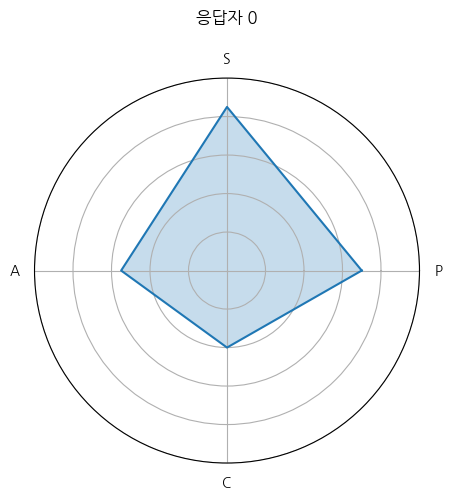

In [185]:
# 평온과 안락 : Serenity 0번
display(df.loc[df['respondent_id'] == '0']['combined'])
plot_radar('0',per_respondent,['P','S','A','C'])

,combined
200,사랑 / 사랑 주고받을 때 행복 느낌
201,건강 / 몸이 건강해야 마음도 건강해서 행복해짐
202,비교 / 비교 없는 삶이 행복함
203,돈 / 물질적 조건이 달성되지 않아도 행복할 수 있지만 물질적 조건이 달성되면 더 ...
204,밥 / 나를 위한 좋은 식사를 했을 때 행복함
205,가을 / 요즘 가을이 너무 예뻐서 행복함
206,아침 / 아침의 싱그러움을 떠올리면 행복함
207,가족 / 우리 가족의 행복이 나의 행복.
208,음악 / 음악공부할 때 행복함
209,공부 / 공부의 참맛을 알았을 때 행복함.


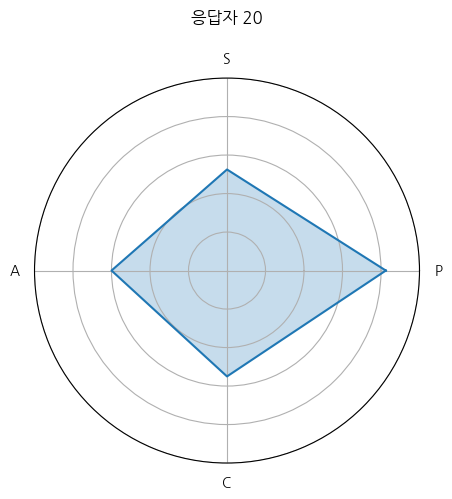

In [186]:
# 즐거움과 기쁨 : Pleasure 10번
display(df.loc[df['respondent_id'] == '20']['combined'])
plot_radar('20',per_respondent,['P','S','A','C'])

,combined
50,가족 / 안정감에서 오는 행복
51,돈 / 돈이 주는 편안함
52,일 / 일이 주는 보람참
53,성취 / 성취에서 오는 자기 만족도
54,친구 / 친구로부터 오는 즐거움
55,술 / 유일한 도파민
56,여행 / 릴렉스된 기분에서 오는 행복
57,다양성 / 다양성에서 오는 신비로움과 신기함
58,배움 / 배움으로써 오는 성장과 행복
59,음식 / 맛있는걸 먹으면서 오는 즐거움


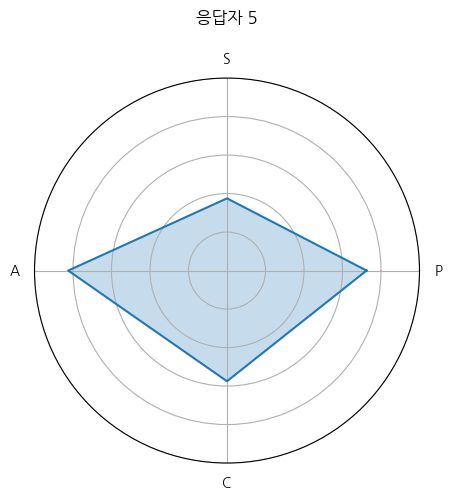

In [128]:
# 성취와 의미 : Achievement 9번
display(df.loc[df['respondent_id'] == '5']['combined'])
plot_radar('5',per_respondent,['P','S','A','C'])

,combined
90,동행 / 함께 걷는 것만으로 좋다
91,사랑 / 사랑의 감정으로 갖게 된다
92,성취 / 원하는 것을 이룸으로 얻게 되니
93,소망 / 무엇인가를 간절히 원하는 것만으로
94,연대 / 누군가와 힘과 마음을 모으는 것으로
95,신앙 / 절대자를 통한 구원의 확신으로
96,찬양 / 마음의 평안을 얻게 하는
97,우정 / 공감할 수 있는 이가 있음으로
98,여행 / 새로운 곳을 찾아 쉼과 여유를 갖기에
99,만족 / 무엇인가 풍성하게 채워지는 느낌


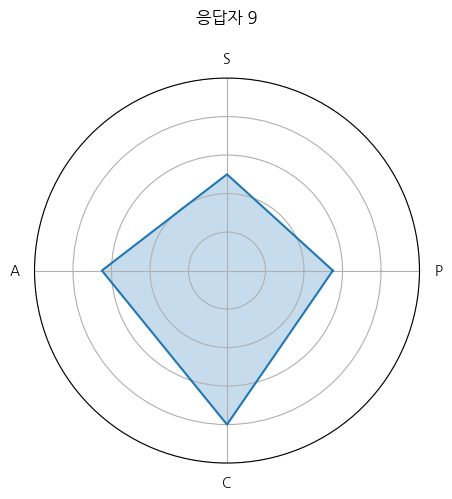

In [187]:
# 관계와 유대 : Connection 9번
display(df.loc[df['respondent_id'] == '9']['combined'])
plot_radar('9',per_respondent,['P','S','A','C'])

,combined
190,기쁨 / 행복한 감정을 기쁠 때 느낌
191,관계 / 관계를 맺어가며 행복을 느리기 때문
192,사랑 / 사랑을 통해 행복을 느끼기 때문
193,쉼 / 쉬어야 행복하기 때문
194,우정 / 우정을 통해 행복감을 느끼기 때문
195,성취 / 성취에 따른 행복이 있기 때문
196,평안 / 평안한 마음을 가져야 행복할 수 있기 때문
197,감사 / 작은 것에도 감사하면 행복해지기 때문
198,여유 / 마음의 여유가 있으면 행복하기 때문
199,칭찬 / 칭찬을 들으면 행복해지기 때문


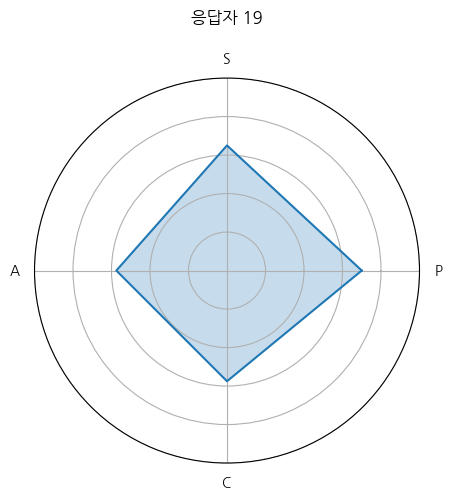

In [130]:
# 한계점 - 라벨의 부재? 그저 균형있는 행복론자?
display(df.loc[df['respondent_id'] == '19']['combined'])
plot_radar('19',per_respondent,['P','S','A','C'])

In [15]:
df.head(5)

,respondent_id,pair_index,word,explanation,combined,S_score_word,S_score_expl,S,P_score_word,P_score_expl,P,A_score_word,A_score_expl,A,C_score_word,C_score_expl,C
0,0,1,자유,모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다,자유 / 모든 걱정과 의무으로부터의 해방된 자유로움이 있을 것 같다,0.928680,0.913144,10.0,0.927908,0.055461,2.5,0.927007,0.295133,5.0,0.896821,0.809340,7.5
1,0,2,만족,행복은 더이상 무언가 바랄 것이 없는 상태일 것이다,만족 / 행복은 더이상 무언가 바랄 것이 없는 상태일 것이다,0.931285,0.245154,10.0,0.946885,0.170714,5.0,0.935575,0.147948,2.5,0.910554,0.251243,7.5
2,0,3,완전,행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함,완전 / 행복한 상태는 어떠한 필요와 의무로부터 벗어나 완전한 상태라고 생각함,0.756111,0.733013,7.5,0.887642,0.833039,10.0,0.871726,0.197205,2.5,0.836830,0.583445,5.0
3,0,4,무욕,행복한 상태는 이미 충분하기에 더한 욕심도 없을 것,무욕 / 행복한 상태는 이미 충분하기에 더한 욕심도 없을 것,0.803643,0.916829,10.0,0.731144,0.917851,7.5,0.727976,0.908540,5.0,0.692604,0.736366,2.5
4,0,5,충분,행복하다면 이미 채워져있어 부족함이 없을 것,충분 / 행복하다면 이미 채워져있어 부족함이 없을 것,0.829465,0.858941,5.0,0.928624,0.930836,10.0,0.901846,0.938609,7.5,0.873279,0.823599,2.5
